In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import pandas as pd
cwd=os.getcwd()
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


**Reading from CSV file and creating a dataframe**

In [ ]:
df = pd.read_csv("file2.csv") 
   
# output the dataframe
print(df)

       Unnamed: 0       image  expression   valence   Arousal
0               0   84433.jpg           1  0.803329  0.111305
1               1  355266.jpg           0  0.031746 -0.007937
2               2  368459.jpg           1  0.761905 -0.547619
3               3  365975.jpg           6 -0.684787  0.179098
4               4   49570.jpg           1  0.690055 -0.131690
...           ...         ...         ...       ...       ...
27607       27607  209036.jpg           0  0.011484 -0.003828
27608       27608  350069.jpg           1  0.547619  0.000000
27609       27609  327174.jpg           1  0.681366  0.034451
27610       27610  371163.jpg           3  0.328751  0.547918
27611       27611   48905.jpg           1  0.750097  0.072590

[27612 rows x 5 columns]


**Importing Xception model**

In [ ]:
model3=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet"
)

83697664/83683744 [==============================] - 0s 0us/step


**Defining new layers for transfer learning**

In [ ]:
for layer in model3.layers:
        layer.trainable=False

In [ ]:
# add new classifier layers
out_1 =GlobalAveragePooling2D()(model3.layers[-1].output)
classi = Dense(512, activation='relu')(out_1)
classi_2=Dense(512, activation='relu')(classi)

expr1 = Dense(100, activation='relu')(classi_2)
expr2=Dense(100, activation='relu')(expr1)
expression = Dense(8, activation='softmax',name='expression')(expr2)

vall1 = Dense(100, activation='relu')(classi_2)
vall2=Dense(100, activation='relu')(vall1)
valence=keras.layers.Dense(1, activation='linear',name='valence')(vall2)

arousal1 = Dense(100, activation='relu')(classi_2)
arousal2=Dense(100, activation='relu')(arousal1)
arrousal=keras.layers.Dense(1, activation='linear',name='arrousal')(arousal2)
# define new model
model3 = Model(inputs=model3.inputs,outputs=[expression,valence,arrousal])
# summarize
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

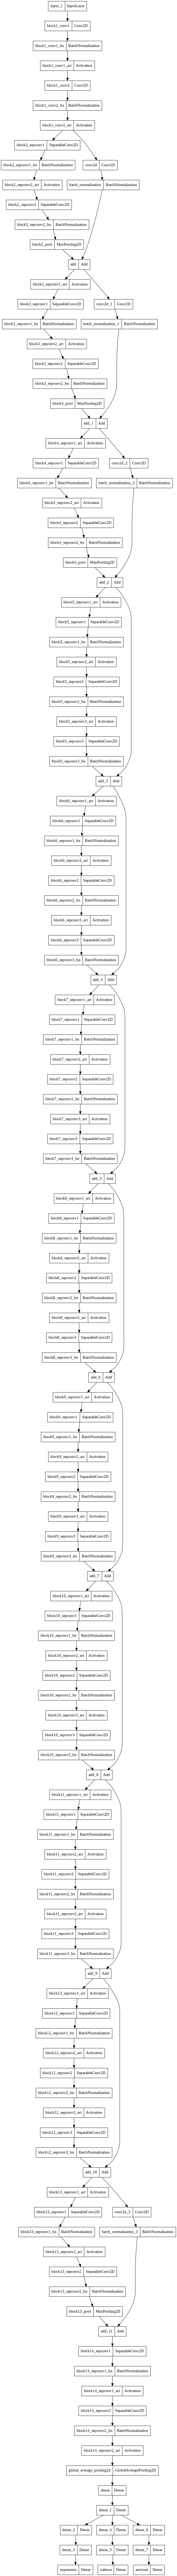

In [ ]:
keras.utils.plot_model(model3, "Xception.png")

**Loading data from dataframe**

In [ ]:
direc='Data/50k/images'

datagen_X=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.xception.preprocess_input)

train_generator_X = datagen_X.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='training',
    shuffle=True,
    seed=42)

valid_generator_X = datagen_X.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='validation',
    shuffle=True,
    seed=42
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 22089 validated image filenames.
Found 5522 validated image filenames.


**Defining loss functions and optimizer**

In [ ]:
#loss and optimizer

def WeightedSoftmax(y_true, y_pred):
  class_weight=tf.convert_to_tensor(np.array([0.57261169,0.57229192,0.62097051,0.7573698,1.21360446,1.21360446,1.80900564,0.62412396,1.83002202]),dtype=tf.float32)
  unreduced_scee=tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss =unreduced_scee(y_true, y_pred)
  weight_mask=tf.gather(class_weight, y_true)
  loss=tf.math.multiplt(loss, weight_mask)
  loss=tf.reduce_mean

loss1=tf.keras.losses.SparseCategoricalCrossentropy(reduction="auto", name="CCE")
loss2=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss3=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
optim=keras.optimizers.Adam(lr=0.001)
metrics=['accuracy']

losses={
    "expression":loss1,
    "valence":loss2,
    "arrousal":loss3
}


model3.compile(loss=losses,optimizer=optim,metrics=metrics,loss_weights=[10,1,1])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model3.load_weights(checkpoint_path)

In [ ]:
tf.config.run_functions_eagerly(True)

**Training and Validation**

In [ ]:
history=model3.fit(
    train_generator_X,
    batch_size=64,
    epochs=10,
    steps_per_epoch=100,
    verbose="auto",
    validation_data=valid_generator_X,
    validation_steps=10,callbacks=[cp_callback],
    shuffle=True
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


100/100 [==============================] - ETA: 0s - loss: 2.9140 - expression_loss: 0.0000e+00 - valence_loss: 0.0820 - arrousal_loss: 2.8320 - expression_accuracy: 0.0380 - valence_accuracy: 0.0220 - arrousal_accuracy: 0.4820
Epoch 1: saving model to training_2/cp.ckpt
100/100 [==============================] - 676s 7s/step - loss: 2.9140 - expression_loss: 0.0000e+00 - valence_loss: 0.0820 - arrousal_loss: 2.8320 - expression_accuracy: 0.0380 - valence_accuracy: 0.0220 - arrousal_accuracy: 0.4820 - val_loss: 3.7605 - val_expression_loss: 9.5367e-10 - val_valence_loss: 0.0974 - val_arrousal_loss: 3.6631 - val_expression_accuracy: 0.0320 - val_valence_accuracy: 0.0300 - val_arrousal_accuracy: 0.4440
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 2.7980 - expression_loss: 2.3842e-10 - valence_loss: 0.0805 - arrousal_loss: 2.7175 - expression_accuracy: 0.0240 - valence_accuracy: 0.0300 - arrousal_accuracy: 0.4600
Epoch 2: saving model to training_2/cp.ckpt
100/100

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'expression_loss', 'valence_loss', 'arrousal_loss', 'expression_accuracy', 'valence_accuracy', 'arrousal_accuracy', 'val_loss', 'val_expression_loss', 'val_valence_loss', 'val_arrousal_loss', 'val_expression_accuracy', 'val_valence_accuracy', 'val_arrousal_accuracy'])


**Training learning curves**

In [ ]:
import matplotlib.pyplot as plt

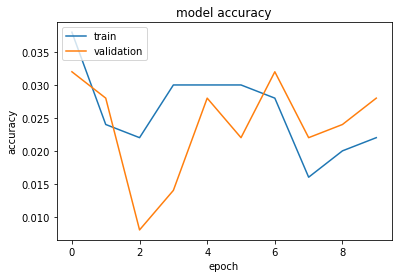

In [ ]:
plt.plot(history.history['expression_accuracy'])
plt.plot(history.history['val_expression_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

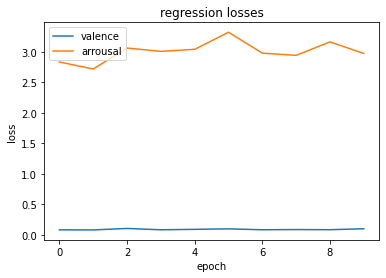

In [ ]:
plt.plot(history.history['valence_loss'])
plt.plot(history.history['arrousal_loss'])
plt.title('regression losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valence','arrousal'], loc='upper left')
plt.show()

**Test data**

In [ ]:
df1 = pd.read_csv("test.csv") 

In [ ]:
direc='test/te/images'

datagen_X=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.xception.preprocess_input)

test_generator_X = datagen_X.flow_from_dataframe(
    dataframe=df1,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=1,
    class_mode="multi_output",
    shuffle=True,
    seed=42)

Found 2000 validated image filenames.


**Metrics on Test Data**

In [ ]:
loss,expression_loss,valence_loss,arrousal_loss,expression_accuracy,valence_accuracy,arrousal_accuracy = model3.evaluate(test_generator_X, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2000/2000 [==============================] - 801s 401ms/step - loss: 3.1303 - expression_loss: 0.0000e+00 - valence_loss: 0.0892 - arrousal_loss: 3.0411 - expression_accuracy: 0.0275 - valence_accuracy: 0.0425 - arrousal_accuracy: 0.4305


In [ ]:
expression_1,valence,arousal = model3.predict(test_generator_X, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2000/2000 [==============================] - 754s 377ms/step


In [ ]:
s_array = df1[["expression"]].to_numpy()

In [ ]:
y_pred = np.argmax(expression_1, axis=1)

**Precision and Recall**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, s_array))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46      2000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.30      2000
   macro avg       0.12      0.04      0.06      2000
weighted avg       1.00      0.30      0.46      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
